In [145]:
import sys
sys.path.append('../')  # Adjust the path accordingly
import warnings
warnings.filterwarnings("ignore")

from DataAnalysis.EventAnalyzer import EventAnalyzer
import pandas as pd
from PrepareDataset.DataEncoder.FeatureCollector import FeatureCollector

from PrepareDataset.DataEncoder.PreprocessLogger import PreprocessLogger

logger = PreprocessLogger(PreprocessLogger.__name__, jupyter=False, file_name="liver.log").logger

In [146]:
## bca data
PROJECT_PATH = "/home/dmitrii/GitHub/ukbb_risk_assessment/"
cohort_path = PROJECT_PATH + 'PrepareDataset/resources/3m_3y/pancreas_3m_3y/'
data_showcase_path = (PROJECT_PATH + 'PrepareDataset/resources/Data_Dictionary_Showcase.csv')

eids_path = cohort_path +'labels.csv'
eids_to_read = pd.read_csv(eids_path)['eid'].tolist()
cardiac_radiomics_path = PROJECT_PATH + "PrepareDataset/resources/cardiac_features/table_all.csv"


In [147]:
len(eids_to_read)

590

In [148]:
feature_collector = FeatureCollector(label_path=(cohort_path + "labels_with_val.csv"), logger=logger)
file_path_to_features = cohort_path + "/preprocessed_features/"
#file_path_to_features = cohort_path + "/encoded_features/"
feature_collector.load_features(data_showcase_path=data_showcase_path, file_path_to_features=file_path_to_features)

2024-11-07 10:15:44,888 - PreprocessLogger - INFO - comorbidity_file_path, icd_code_dict_file_path and interested_date are not provided
2024-11-07 10:15:44,888 - PreprocessLogger - INFO - comorbidity_file_path, icd_code_dict_file_path and interested_date are not provided
2024-11-07 10:15:44,888 - PreprocessLogger - INFO - comorbidity_file_path, icd_code_dict_file_path and interested_date are not provided
2024-11-07 10:15:44,888 - PreprocessLogger - INFO - comorbidity_file_path, icd_code_dict_file_path and interested_date are not provided
INFO:PreprocessLogger:comorbidity_file_path, icd_code_dict_file_path and interested_date are not provided


In [149]:
set_of_features= set([
    #"cardiac_radiomics",
    #"bca_norm", 
    #"elixhauser_comorbidities", 
    #"basic_features", 
    #"met_physical_activity", 
    #"smoking", 
    #"alcohol", 
    #"general_health", 
    #"diet", 
    #"clinical_biomarkers"
    #"total_radiomics",
])

In [150]:
df_labels = pd.read_csv(cohort_path + "labels_with_val.csv")

In [151]:
df_labels['split'].value_counts()

split
train    424
test     118
val       48
Name: count, dtype: int64

In [152]:
features = feature_collector.get_features(set_of_features)

2024-11-07 10:15:51,294 - PreprocessLogger - INFO - Intersected columns: 
{'eid'}
2024-11-07 10:15:51,294 - PreprocessLogger - INFO - Intersected columns: 
{'eid'}
2024-11-07 10:15:51,294 - PreprocessLogger - INFO - Intersected columns: 
{'eid'}
2024-11-07 10:15:51,294 - PreprocessLogger - INFO - Intersected columns: 
{'eid'}
INFO:PreprocessLogger:Intersected columns: 
{'eid'}


In [153]:
pd.DataFrame(features.columns)

,0
0,eid
1,event
2,time_to_event
3,split
4,Abdominal fat ratio
5,Anterior thigh muscle fat infiltration (MFI) (...
6,Anterior thigh muscle fat infiltration (MFI) (...
7,Muscle fat infiltration
8,Posterior thigh muscle fat infiltration (MFI) ...
9,Posterior thigh muscle fat infiltration (MFI) ...


In [154]:
features["split"].value_counts()

split
train    472
test     118
Name: count, dtype: int64

In [155]:
# replace split column in features_ckd with df_labels split column merging by eid
features.drop(columns=["split"], inplace=True)
features = features.merge(df_labels[["eid", "split"]], on="eid", how="left")

In [156]:
features["split"].value_counts()

split
train    424
test     118
val       48
Name: count, dtype: int64

In [75]:
features.drop(columns=["event", "time_to_event", "split"], inplace=True)
#features.to_csv("/home/dmitrii/GitHub/ukbb_risk_assessment/PrepareDataset/resources/3m_3y/cvd2_3m_3y/tabular_final_preprocessed/bca+cardiac.csv")

In [76]:
features = pd.read_csv("/home/dmitrii/GitHub/ukbb_risk_assessment/data/projects/risk_assessment/labels/3m_3y/cvd2_3m_3y/tabular_final_preprocessed/bca+cardiac+nonimage_tabular.csv")
len(features.columns)

252

In [157]:
features.columns

Index(['eid', 'event', 'time_to_event', 'Abdominal fat ratio',
       'Anterior thigh muscle fat infiltration (MFI) (left)',
       'Anterior thigh muscle fat infiltration (MFI) (right)',
       'Muscle fat infiltration',
       'Posterior thigh muscle fat infiltration (MFI) (left)',
       'Posterior thigh muscle fat infiltration (MFI) (right)',
       'Total abdominal adipose tissue index', 'Weight-to-muscle ratio',
       'Total trunk fat volume',
       'Abdominal subcutaneous adipose tissue volume (ASAT)',
       'Visceral adipose tissue volume (VAT)',
       'Total thigh fat-free muscle volume',
       'Anterior thigh fat-free muscle volume (left)',
       'Anterior thigh fat-free muscle volume (right)',
       'Posterior thigh fat-free muscle volume (left)',
       'Posterior thigh fat-free muscle volume (right)', 'split'],
      dtype='object')

In [158]:
ca = EventAnalyzer(features, logger=logger)
ca.remove_one_value_columns()

2024-11-07 10:16:11,121 - PreprocessLogger - INFO - Removed one value columns
2024-11-07 10:16:11,121 - PreprocessLogger - INFO - Removed one value columns
2024-11-07 10:16:11,121 - PreprocessLogger - INFO - Removed one value columns
2024-11-07 10:16:11,121 - PreprocessLogger - INFO - Removed one value columns
INFO:PreprocessLogger:Removed one value columns
2024-11-07 10:16:11,125 - PreprocessLogger - INFO - Removed one value columns: Index([], dtype='object')
2024-11-07 10:16:11,125 - PreprocessLogger - INFO - Removed one value columns: Index([], dtype='object')
2024-11-07 10:16:11,125 - PreprocessLogger - INFO - Removed one value columns: Index([], dtype='object')
2024-11-07 10:16:11,125 - PreprocessLogger - INFO - Removed one value columns: Index([], dtype='object')
INFO:PreprocessLogger:Removed one value columns: Index([], dtype='object')


In [159]:
corr_table = ca.get_correlated_with_target(threshold=0)

2024-11-07 10:16:12,371 - PreprocessLogger - INFO - Getting correlated features with target
2024-11-07 10:16:12,371 - PreprocessLogger - INFO - Getting correlated features with target
2024-11-07 10:16:12,371 - PreprocessLogger - INFO - Getting correlated features with target
2024-11-07 10:16:12,371 - PreprocessLogger - INFO - Getting correlated features with target
INFO:PreprocessLogger:Getting correlated features with target
2024-11-07 10:16:12,390 - PreprocessLogger - INFO - Correlated features with target: [('Total abdominal adipose tissue index', 0.3459024416076208), ('Total trunk fat volume', 0.31311011258460686), ('Visceral adipose tissue volume (VAT)', 0.31310463141326766), ('Abdominal subcutaneous adipose tissue volume (ASAT)', 0.2807821029262971), ('Posterior thigh muscle fat infiltration (MFI) (left)', 0.26235604981642796), ('Posterior thigh muscle fat infiltration (MFI) (right)', 0.24337489063221396), ('Anterior thigh muscle fat infiltration (MFI) (left)', 0.2389396114406326

In [160]:
pd.DataFrame(corr_table)

,0,1
0,Total abdominal adipose tissue index,0.345902
1,Total trunk fat volume,0.313110
2,Visceral adipose tissue volume (VAT),0.313105
3,Abdominal subcutaneous adipose tissue volume (...,0.280782
4,Posterior thigh muscle fat infiltration (MFI) ...,0.262356
5,Posterior thigh muscle fat infiltration (MFI) ...,0.243375
6,Anterior thigh muscle fat infiltration (MFI) (...,0.238940
7,Weight-to-muscle ratio,0.231160
8,Muscle fat infiltration,0.216120
9,Abdominal fat ratio,0.209710


In [161]:
ca.data.columns

Index(['eid', 'event', 'time_to_event', 'Abdominal fat ratio',
       'Anterior thigh muscle fat infiltration (MFI) (left)',
       'Anterior thigh muscle fat infiltration (MFI) (right)',
       'Muscle fat infiltration',
       'Posterior thigh muscle fat infiltration (MFI) (left)',
       'Posterior thigh muscle fat infiltration (MFI) (right)',
       'Total abdominal adipose tissue index', 'Weight-to-muscle ratio',
       'Total trunk fat volume',
       'Abdominal subcutaneous adipose tissue volume (ASAT)',
       'Visceral adipose tissue volume (VAT)',
       'Total thigh fat-free muscle volume',
       'Anterior thigh fat-free muscle volume (left)',
       'Anterior thigh fat-free muscle volume (right)',
       'Posterior thigh fat-free muscle volume (left)',
       'Posterior thigh fat-free muscle volume (right)', 'split'],
      dtype='object')

In [162]:
ca.data.drop(columns=["10P Liver PDFF (proton density fat fraction)", 'FR liver PDFF mean', 'Total lean tissue volume', 'Total thigh fat-free muscle volume'], inplace=True)

KeyError: "['10P Liver PDFF (proton density fat fraction)', 'FR liver PDFF mean', 'Total lean tissue volume'] not found in axis"

In [163]:
ca.split_data()

2024-11-07 10:16:21,556 - PreprocessLogger - INFO - Splitting data into training and testing sets
2024-11-07 10:16:21,556 - PreprocessLogger - INFO - Splitting data into training and testing sets
2024-11-07 10:16:21,556 - PreprocessLogger - INFO - Splitting data into training and testing sets
2024-11-07 10:16:21,556 - PreprocessLogger - INFO - Splitting data into training and testing sets
INFO:PreprocessLogger:Splitting data into training and testing sets


In [164]:
def _visualize_results(results):
    df = pd.DataFrame({
    model: {
        metric: f"{values['mean']:.3f} ± {values['std']:.3f}"
        for metric, values in metrics.items()
    }
    for model, metrics in results.items()
    }).T
    return df

In [171]:
import autogluon.tabular as ag

from autogluon.common import space
import random
import torch
import numpy as np
from sklearn.metrics import accuracy_score, balanced_accuracy_score, f1_score, roc_auc_score
from itertools import product
from autogluon.common import space


def train_and_evaluate(ca):
    seeds = ca.RANDOM_SET_SEED[:5]
    
    # Prepare the training and test datasets
    train_data = ca.data[ca.data['split'] == 'train'].drop(columns=['split', 'eid', 'event', 'time_to_event']).copy()
    train_data['label'] = ca.data[ca.data['split'] == 'train']['event'].copy()
    test_data = ca.data[ca.data['split'] == 'test'].drop(columns=['split', 'eid', 'event', 'time_to_event']).copy()
    test_data['label'] = ca.data[ca.data['split'] == 'test']['event'].copy()
    val_data = ca.data[ca.data['split'] == 'val'].drop(columns=['split', 'eid', 'event', 'time_to_event']).copy()
    val_data['label'] = ca.data[ca.data['split'] == 'val']['event'].copy()
    
    results = {}

    models_to_train = ['RF', 'XGB', 'NN_TORCH'] #['XT', 'RF', 'XGB', 'NN_TORCH', 'CAT', 'GBM']

    
    for model in models_to_train:
        results[model] = {'accuracy': [], 'balanced_accuracy': [], 'f1': [], 'roc_auc': [], 'feature_importances': {"test":[], "test_val": []}}
        for seed in seeds:

            predictor = ag.TabularPredictor(label='label', eval_metric='balanced_accuracy', path=f'./autogluon/model_{model}_seed_{seed}', verbosity=2, problem_type='binary')
            hyperparameters = {
                'RF': {
                    'RF': {
                        'random_state': seed,  # Use your seed here
                    }
                },  
                'XGB': {
                    'XGB': {
                        'random_state': seed,
                        'subsample': 0.98,
                        'colsample_bytree': 0.98,
                    }
                },
                'NN_TORCH': {
                    'NN_TORCH': {
                        "seed_value":seed,
                    }
                }
            }
            predictor.fit(
                train_data=train_data,
                tuning_data=val_data,  # Set validation data for hyperparameter tuning
                hyperparameters=hyperparameters[model],
                time_limit=600,   # Time limit per seed (10 minutes)
                num_bag_folds=0,  # No bagging
                num_stack_levels=0,  # No stacking
                presets='best_quality',  # Best quality preset
            )
            
            y_pred = predictor.predict(test_data)
            y_proba = predictor.predict_proba(test_data)
            y_proba = y_proba.to_numpy()[:, 1]
            metrics = {
                "accuracy": accuracy_score(test_data['label'], y_pred),
                "balanced_accuracy": balanced_accuracy_score(test_data['label'], y_pred),
                "f1": f1_score(test_data['label'], y_pred),
                "roc_auc": roc_auc_score(test_data['label'], y_proba),
            }
    
            # Store the metrics for this model and seed
            for metric in metrics:
                results[model][metric].append(metrics[metric])
            test_val_data = pd.concat([test_data, val_data])
            results[model]['feature_importances']["test"].append(predictor.feature_importance(data=test_data, num_shuffle_sets=5))
            results[model]['feature_importances']["test_val"].append(predictor.feature_importance(data=test_val_data, num_shuffle_sets=5))
                
                
            

        
    # Calculate mean and standard deviation across seeds for each model
    results_combined = {}
    for model_name in results:
        results_combined[model_name] = {}
        for metric in results[model_name]:
            if metric != 'feature_importances':
                results_combined[model_name][metric] = {
                    "mean": np.mean(results[model_name][metric]),
                    "std": np.std(results[model_name][metric])
                }
            else:
                results_combined[model_name][metric] = results[model_name][metric]
    
    return results_combined#, best_model_predictor


results = train_and_evaluate(ca)

Presets specified: ['best_quality']
Stack configuration (auto_stack=True): num_stack_levels=0, num_bag_folds=0, num_bag_sets=1
Beginning AutoGluon training ... Time limit = 600s
AutoGluon will save models to "./autogluon/model_RF_seed_1514"
=================== System Info ===================
AutoGluon Version:  1.1.0
Python Version:     3.10.13
Operating System:   Linux
Platform Machine:   x86_64
Platform Version:   #45~22.04.1-Ubuntu SMP PREEMPT_DYNAMIC Wed Sep 11 15:25:05 UTC 2
CPU Count:          48
Memory Avail:       230.46 GB / 251.53 GB (91.6%)
Disk Space Avail:   88.92 GB / 595.78 GB (14.9%)
Train Data Rows:    424
Train Data Columns: 16
Tuning Data Rows:    48
Tuning Data Columns: 16
Label Column:       label
Problem Type:       binary
Preprocessing data ...
Selected class <--> label mapping:  class 1 = 1, class 0 = 0
Using Feature Generators to preprocess the data ...
Fitting AutoMLPipelineFeatureGenerator...
	Available Memory:                    235992.29 MB
	Train Data (Ori

In [172]:
# remove feature_importances from results
results_visualized = {model: {metric: values for metric, values in metrics.items() if metric != 'feature_importances'} for model, metrics in results.items()}

In [173]:
_visualize_results(results_visualized)

,accuracy,balanced_accuracy,f1,roc_auc
RF,0.644 ± 0.011,0.644 ± 0.011,0.630 ± 0.014,0.733 ± 0.001
XGB,0.661 ± 0.013,0.661 ± 0.013,0.615 ± 0.006,0.719 ± 0.015
NN_TORCH,0.676 ± 0.021,0.676 ± 0.021,0.647 ± 0.023,0.760 ± 0.005


In [96]:
# save feature importances with folder structure as keys
import os
import json
dataset_name = "cvd2WOBCA"
save_dir = "/home/dmitrii/GitHub/ukbb_risk_assessment/analysisNumericFeatures/resources/feature_importances/permutation_importances"
for model in results:
    for split in results[model]['feature_importances']:
        for i, fi in enumerate(results[model]['feature_importances'][split]):
            if not os.path.exists(f"{save_dir}/{dataset_name}/{model}/{split}/"):
                os.makedirs(f"{save_dir}/{dataset_name}/{model}/{split}/")
            fi.to_csv(f"{save_dir}/{dataset_name}/{model}/{split}/feature_importances_{ca.RANDOM_SET_SEED[i]}.csv")

In [1665]:
results['XGB']['feature_importances']

{'mean': 0.9135335648301985, 'std': 1.8376083552155715}

In [1648]:
train_data = ca.data[ca.data['split'] == 'train'].drop(columns=['split', 'eid', 'event', 'time_to_event']).copy()
train_data['label'] = ca.data[ca.data['split'] == 'train']['event'].copy()
test_data = ca.data[ca.data['split'] == 'test'].drop(columns=['split', 'eid', 'event', 'time_to_event']).copy()
test_data['label'] = ca.data[ca.data['split'] == 'test']['event'].copy()

In [1653]:
model = best_model_predictor[0]._trainer.load_model("XGBoost")

In [1654]:
# take only column from model.features
train_data = train_data[model.features + ['label']]
test_data = test_data[model.features + ['label']]

In [1655]:
model = best_model_predictor[0]._trainer.load_model("XGBoost")
len(model.model.feature_importances_), len(model.features), len(train_data)

(219, 220, 436)

In [1651]:
all_feature_importances = []
for predictor in best_model_predictor:
    model = predictor._trainer.load_model("XGBoost")
    feature_importances = model.model.feature_importances_
    feature_names = model.features
    feature_importances = pd.DataFrame({
        'feature': feature_names,
        'importance': feature_importances
    })
    all_feature_importances.append(feature_importances)

ValueError: All arrays must be of the same length

In [1615]:
all_metrics = []
seeds = [1514, 0, 42, 867228, 29847]
for i, predictor in enumerate(best_model_predictor):
    model = predictor._trainer.load_model("XGBoost")
    model.model.set_params(random_state=seeds[i], subsample=0.95, colsample_by_tree=0.9)
    model.model.fit(train_data.drop(columns=['label']), train_data['label'])
    y_pred = model.model.predict(test_data.drop(columns=['label']))
    y_proba = model.model.predict_proba(test_data.drop(columns=['label']))
    y_proba = y_proba[:, 1]
    y_labels = test_data['label']
    metrics = {
        "accuracy": accuracy_score(y_labels, y_pred),
        "balanced_accuracy": balanced_accuracy_score(y_labels, y_pred),
        "f1": f1_score(y_labels, y_pred),
        "roc_auc": roc_auc_score(y_labels, y_proba),
    }
    all_metrics.append(metrics)
print("Mean metrics across seeds:")
print("Balanced Accuracy: ", np.mean([x['balanced_accuracy'] for x in all_metrics]), np.std([x['balanced_accuracy'] for x in all_metrics]))

Mean metrics across seeds:
Balanced Accuracy:  0.5516942148760331 0.013674214241236647


In [1538]:
from sklearn.ensemble import RandomForestClassifier
# import xgb
from xgboost import XGBClassifier
rf = RandomForestClassifier(random_state=1514, max_leaf_nodes=15000, n_estimators=300)

# Assuming 'predictor' is your AutoGluon predictor and 'data' is your original dataset
y = train_data['label']
X = train_data.drop(columns=['label'])


In [1539]:
rf.fit(X, y)
y_pred = rf.predict(test_data.drop(columns=['label']))
y_proba = rf.predict_proba(test_data.drop(columns=['label']))
y_proba = y_proba[:, 1]
metrics = {
    "accuracy": accuracy_score(test_data['label'], y_pred),
    "balanced_accuracy": balanced_accuracy_score(test_data['label'], y_pred),
    "f1": f1_score(test_data['label'], y_pred),
    "roc_auc": roc_auc_score(test_data['label'], y_proba),
}
metrics

{'accuracy': 0.5819672131147541,
 'balanced_accuracy': 0.5819672131147541,
 'f1': 0.5853658536585366,
 'roc_auc': 0.5880139747379737}

In [1540]:
importances = rf.feature_importances_
feature_names = rf.feature_names_in_
feature_importances = pd.DataFrame({
    'feature': feature_names,
    'importance': importances
})

In [1658]:
from sklearn.ensemble import RandomForestClassifier

from sklearn.metrics import accuracy_score, balanced_accuracy_score, f1_score, roc_auc_score
import pandas as pd
from xgboost import XGBClassifier

# Assuming 'train_data' and 'test_data' are your dataframes
y_train = train_data['label']
X_train = train_data.drop(columns=['label'])
y_test = test_data['label']
X_test = test_data.drop(columns=['label'])

# List of seeds
seeds = [1514, 0, 42, 867228, 29847]

# To store metrics and feature importances
all_metrics = []
all_feature_importances = []

for seed in seeds:
    # Initialize RandomForest with current seed
    rf = RandomForestClassifier(random_state=seed, max_leaf_nodes=15000, n_estimators=300)
    #rf = XGBClassifier(random_state=seed, subsample=0.95, colsample_by_tree=0.95, booster='gbtree', objective='binary:logistic', base_score=5E-1)
    
    # Fit the model
    rf.fit(X_train, y_train)
    
    # Predictions
    y_pred = rf.predict(X_test)
    y_proba = rf.predict_proba(X_test)[:, 1]
    
    # Compute metrics
    metrics = {
        "seed": seed,
        "accuracy": accuracy_score(y_test, y_pred),
        "balanced_accuracy": balanced_accuracy_score(y_test, y_pred),
        "f1": f1_score(y_test, y_pred),
        "roc_auc": roc_auc_score(y_test, y_proba)
    }
    all_metrics.append(metrics)
    
    # Compute feature importances
    feature_importances = pd.DataFrame({
        'feature': rf.feature_names_in_,
        'importance': rf.feature_importances_,
        'seed': seed
    })
    all_feature_importances.append(feature_importances)


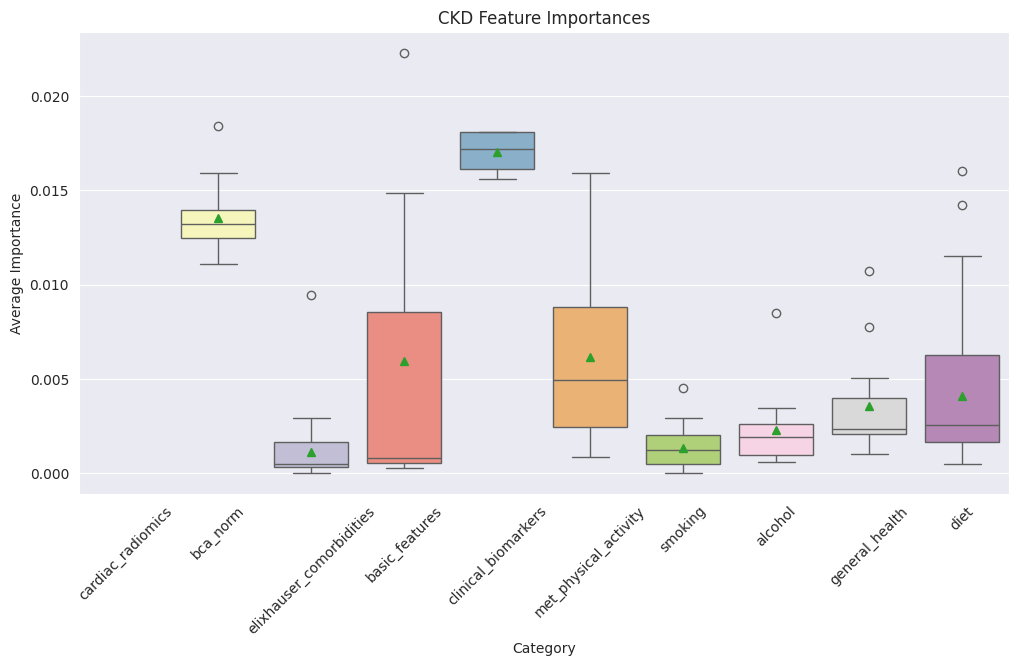

In [1659]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

def plot_average_feature_importance_boxplot(all_feature_importances, category_dict, title=""):
    """
    Plots a boxplot for average feature importances by category, showing all categories, 
    even those without any features, but leaving them empty.

    Parameters:
    all_feature_importances (list): List of DataFrames, each containing feature importances for a seed 
                                    with columns 'feature', 'importance', and 'seed'.
    category_dict (dict): Dictionary where keys are category names and values are lists of features.

    Returns:
    None: Displays the boxplot.
    """
    # Concatenate all DataFrames in the list to form a single DataFrame
    combined_feature_importances_df = pd.concat(all_feature_importances, ignore_index=True)
    
    # Calculate average importance for each feature across all seeds
    avg_feature_importances_df = combined_feature_importances_df.groupby('feature')['importance'].mean().reset_index()
    
    # Prepare the data for the boxplot
    plot_data = []

    for category, features in category_dict.items():
        # Filter for the relevant features in the current category based on averaged importances
        category_data = avg_feature_importances_df[avg_feature_importances_df['feature'].isin(features)]
        if not category_data.empty:
            # Assign category and append to plot_data list
            category_data = category_data.assign(Category=category)  # Add 'Category' column
        else:
            # If no data for this category, create a placeholder with NaN importance
            placeholder_data = pd.DataFrame({
                'feature': [np.nan],  # NaN feature to indicate no data
                'importance': [np.nan],  # NaN importance to indicate no data
                'Category': [category]  # Add the category name
            })
            plot_data.append(placeholder_data)
        
        plot_data.append(category_data)
    
    # Combine all data into a single DataFrame
    combined_plot_data = pd.concat(plot_data, ignore_index=True)

    # Plotting the boxplot using seaborn
    plt.figure(figsize=(12, 6))
    sns.boxplot(x='Category', y='importance', data=combined_plot_data, palette='Set3', showmeans=True)
    plt.title(title)
    plt.xlabel('Category')
    plt.ylabel('Average Importance')
    plt.xticks(rotation=45)
    plt.show()

# Example usage
plot_average_feature_importance_boxplot(all_feature_importances, features_by_category, title="CKD Feature Importances")


In [1660]:
#mean and std of metris
mean, std = np.mean([x['balanced_accuracy'] for x in all_metrics]), np.std([x['balanced_accuracy'] for x in all_metrics])
print(f"Mean Balanced Accuracy: {mean:.3f} ± {std:.3f}")

Mean Balanced Accuracy: 0.549 ± 0.019


In [1546]:
# save all_feature_importances
import pandas as pd
all_feature_importances_df = pd.concat(all_feature_importances, ignore_index=True)

In [1547]:
all_feature_importances_df.to_csv("/home/dmitrii/GitHub/ukbb_risk_assessment/analysisNumericFeatures/resources/feature_importances/ckd_feature_importances.csv")

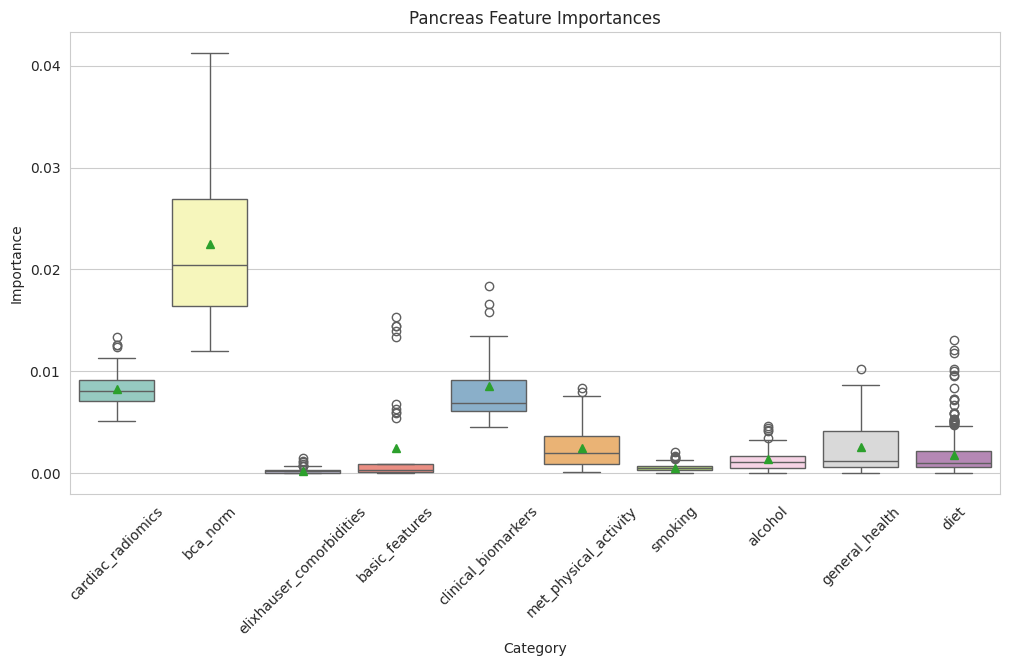

In [1298]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

def plot_feature_importance_boxplot(all_feature_importances, category_dict, title=""):
    """
    Plots a boxplot for feature importances by category, showing all categories,
    including data from multiple seeds.

    Parameters:
    all_feature_importances (list): List of DataFrames, each containing feature importances for a seed 
                                    with columns 'feature', 'importance', and 'seed'.
    category_dict (dict): Dictionary where keys are category names and values are lists of features.

    Returns:
    None: Displays the boxplot.
    """
    # Concatenate all DataFrames in the list to form a single DataFrame
    combined_feature_importances_df = pd.concat(all_feature_importances, ignore_index=True)
    
    # Prepare the data for the boxplot
    plot_data = []

    for category, features in category_dict.items():
        # Filter for the relevant features in the current category across all seeds
        category_data = combined_feature_importances_df[combined_feature_importances_df['feature'].isin(features)]
        if not category_data.empty:
            # Append category and importance values to the plot_data list
            category_data = category_data.assign(Category=category)  # Add 'Category' column
            plot_data.append(category_data)
    
    # Combine all data into a single DataFrame
    combined_plot_data = pd.concat(plot_data, ignore_index=True)

    # Plotting the boxplot using seaborn
    plt.figure(figsize=(12, 6))
    sns.boxplot(x='Category', y='importance', data=combined_plot_data, palette='Set3', showmeans=True)
    plt.title(title)
    plt.xlabel('Category')
    plt.ylabel('Importance')
    plt.xticks(rotation=45)
    plt.show()

plot_feature_importance_boxplot(all_feature_importances, features_by_category, title="Pancreas Feature Importances")

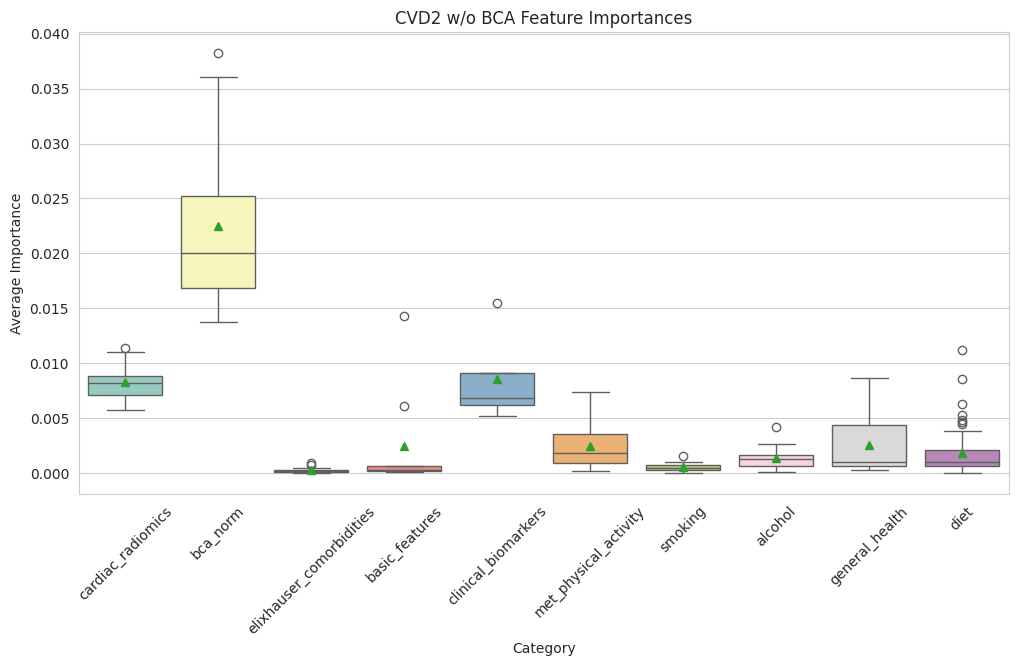

In [1297]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

def plot_average_feature_importance_boxplot(all_feature_importances, category_dict, title=""):
    """
    Plots a boxplot for average feature importances by category, showing all categories.

    Parameters:
    all_feature_importances (list): List of DataFrames, each containing feature importances for a seed 
                                    with columns 'feature', 'importance', and 'seed'.
    category_dict (dict): Dictionary where keys are category names and values are lists of features.

    Returns:
    None: Displays the boxplot.
    """
    # Concatenate all DataFrames in the list to form a single DataFrame
    combined_feature_importances_df = pd.concat(all_feature_importances, ignore_index=True)
    
    # Calculate average importance for each feature across all seeds
    avg_feature_importances_df = combined_feature_importances_df.groupby('feature')['importance'].mean().reset_index()
    
    # Prepare the data for the boxplot
    plot_data = []

    for category, features in category_dict.items():
        # Filter for the relevant features in the current category based on averaged importances
        category_data = avg_feature_importances_df[avg_feature_importances_df['feature'].isin(features)]
        if not category_data.empty:
            # Assign category and append to plot_data list
            category_data = category_data.assign(Category=category)  # Add 'Category' column
            plot_data.append(category_data)
    
    # Combine all data into a single DataFrame
    combined_plot_data = pd.concat(plot_data, ignore_index=True)

    # Plotting the boxplot using seaborn
    plt.figure(figsize=(12, 6))
    sns.boxplot(x='Category', y='importance', data=combined_plot_data, palette='Set3', showmeans=True)
    plt.title(title)
    plt.xlabel('Category')
    plt.ylabel('Average Importance')
    plt.xticks(rotation=45)
    plt.show()

plot_average_feature_importance_boxplot(all_feature_importances, features_by_category, title="CVD2 w/o BCA Feature Importances")
# Example usage:
# Assuming 'all_feature_importances' is a list of DataFrames containing feature importances from all seeds
# with columns: 'feature', 'importance', and 'seed'.

# Example category_dict:
# category_dict = {
#     'Category1': ['feature1', 'feature2'],
#     'Category2': ['feature3', 'feature4'],
#     # ... other categories


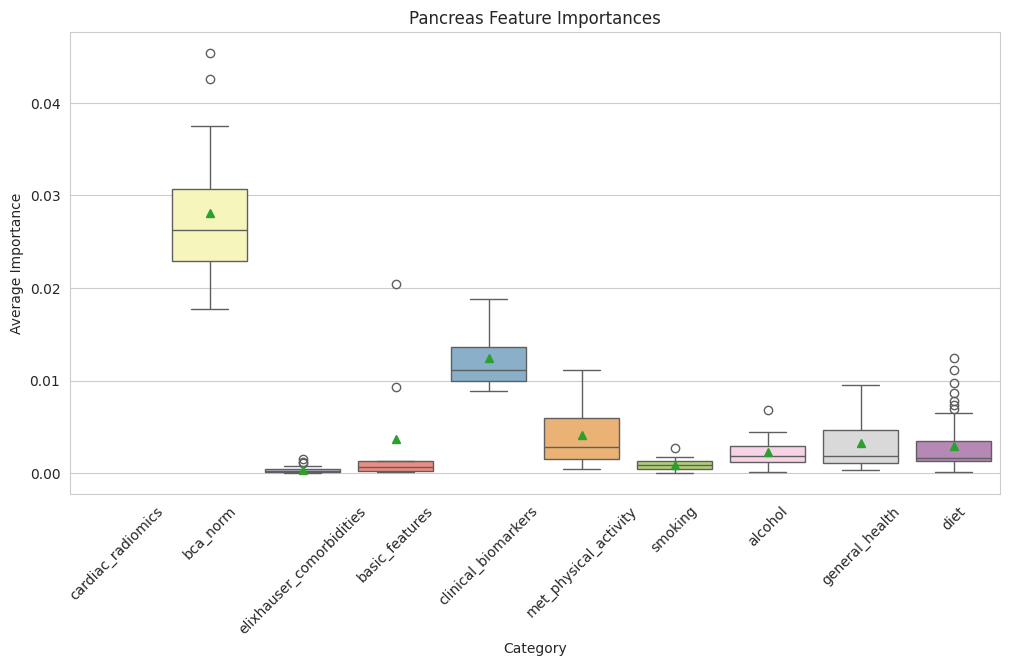

In [1264]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

def plot_average_feature_importance_boxplot(all_feature_importances, category_dict, title=""):
    """
    Plots a boxplot for average feature importances by category, showing all categories, 
    even those without any features, but leaving them empty.

    Parameters:
    all_feature_importances (list): List of DataFrames, each containing feature importances for a seed 
                                    with columns 'feature', 'importance', and 'seed'.
    category_dict (dict): Dictionary where keys are category names and values are lists of features.

    Returns:
    None: Displays the boxplot.
    """
    # Concatenate all DataFrames in the list to form a single DataFrame
    combined_feature_importances_df = pd.concat(all_feature_importances, ignore_index=True)
    
    # Calculate average importance for each feature across all seeds
    avg_feature_importances_df = combined_feature_importances_df.groupby('feature')['importance'].mean().reset_index()
    
    # Prepare the data for the boxplot
    plot_data = []

    for category, features in category_dict.items():
        # Filter for the relevant features in the current category based on averaged importances
        category_data = avg_feature_importances_df[avg_feature_importances_df['feature'].isin(features)]
        if not category_data.empty:
            # Assign category and append to plot_data list
            category_data = category_data.assign(Category=category)  # Add 'Category' column
        else:
            # If no data for this category, create a placeholder with NaN importance
            placeholder_data = pd.DataFrame({
                'feature': [np.nan],  # NaN feature to indicate no data
                'importance': [np.nan],  # NaN importance to indicate no data
                'Category': [category]  # Add the category name
            })
            plot_data.append(placeholder_data)
        
        plot_data.append(category_data)
    
    # Combine all data into a single DataFrame
    combined_plot_data = pd.concat(plot_data, ignore_index=True)

    # Plotting the boxplot using seaborn
    plt.figure(figsize=(12, 6))
    sns.boxplot(x='Category', y='importance', data=combined_plot_data, palette='Set3', showmeans=True)
    plt.title(title)
    plt.xlabel('Category')
    plt.ylabel('Average Importance')
    plt.xticks(rotation=45)
    plt.show()

# Example usage
plot_average_feature_importance_boxplot(all_feature_importances, features_by_category, title="Pancreas Feature Importances")


In [1073]:
# read json
import json
with open('./resources/feature_importances/features_by_category.json') as f:
    features_by_category = json.load(f)

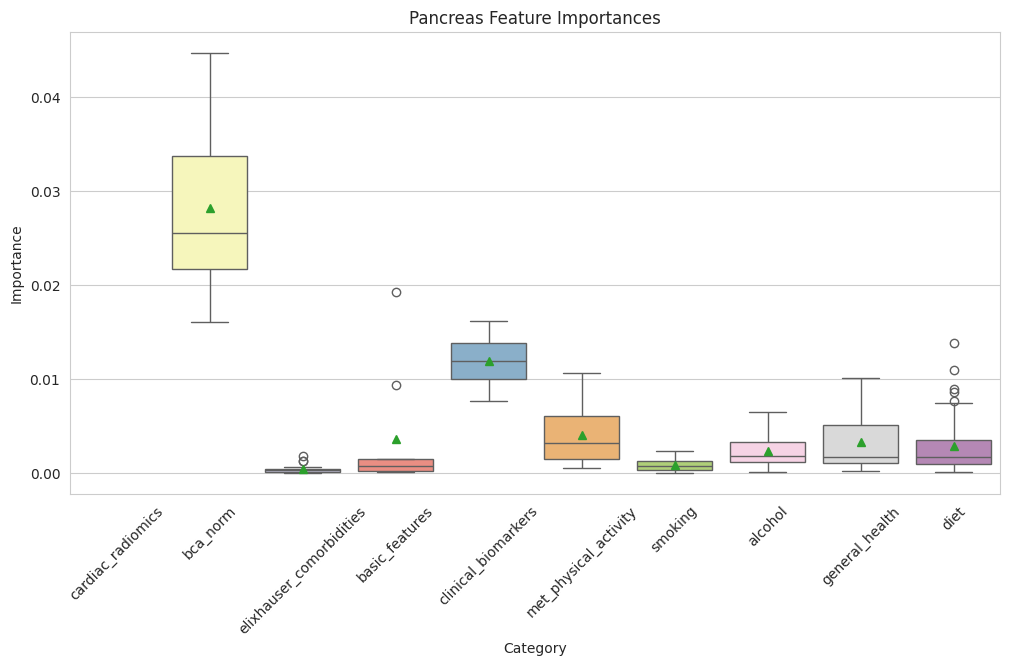

In [1074]:
plot_feature_importance_boxplot(feature_importances, features_by_category, title="Pancreas Feature Importances")

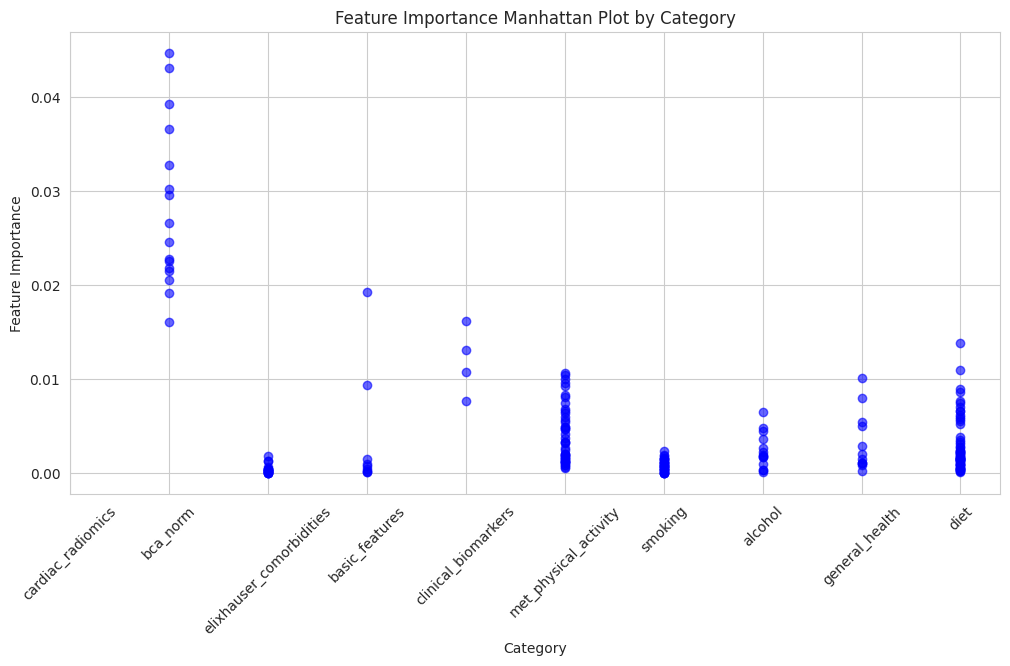

In [1076]:
def plot_feature_importance_manhattan(df, category_dict):
    """
    Plots a Manhattan plot for feature importances by category.

    Parameters:
    df (pd.DataFrame): DataFrame with columns 'feature' and 'importance'.
    category_dict (dict): Dictionary where keys are category names and values are lists of features.

    Returns:
    None: Displays the Manhattan plot.
    """
    # Create a reverse lookup for category from feature
    feature_to_category = {feature: category for category, features in category_dict.items() for feature in features}
    
    # Map each feature to its category
    df['category'] = df['feature'].map(feature_to_category)
    
    # Assign a numeric value to each category
    category_mapping = {category: idx for idx, category in enumerate(category_dict.keys())}
    df['category_id'] = df['category'].map(category_mapping)

    # Plotting the Manhattan plot
    plt.figure(figsize=(12, 6))
    plt.scatter(df['category_id'], df['importance'], c='blue', alpha=0.6)
    
    # Add horizontal lines for significance thresholds if necessary
    # plt.axhline(y=0.1, color='r', linestyle='--', label='Threshold')

    # Customize x-axis with category labels
    plt.xticks(ticks=list(category_mapping.values()), labels=list(category_mapping.keys()), rotation=45)
    plt.xlabel('Category')
    plt.ylabel('Feature Importance')
    plt.title('Feature Importance Manhattan Plot by Category')
    plt.grid(True)
    plt.show()

plot_feature_importance_manhattan(feature_importances, features_by_category)

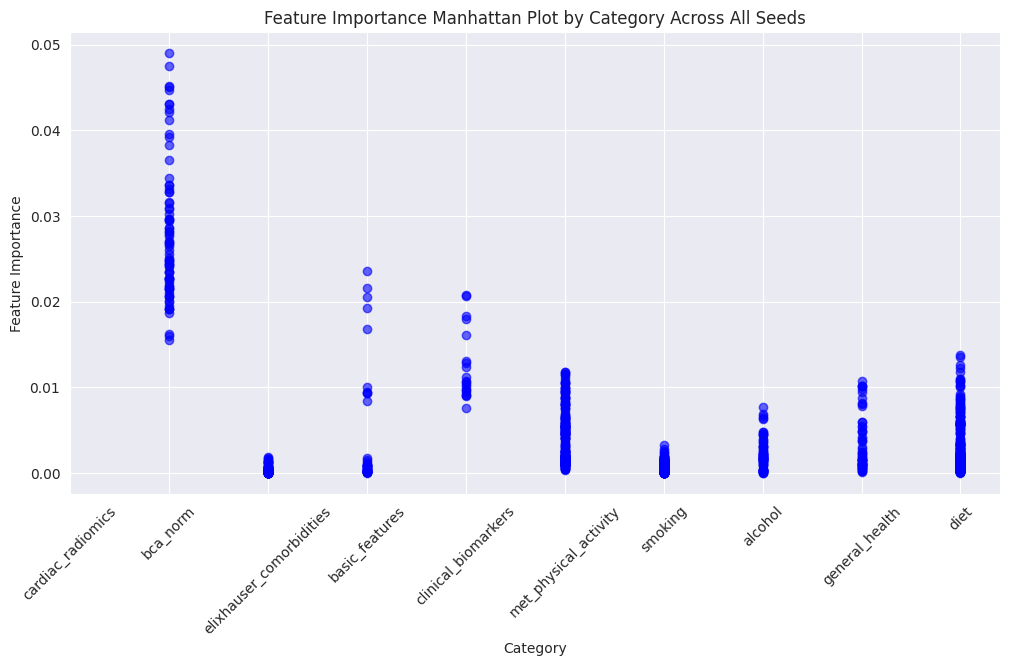

In [1086]:
import matplotlib.pyplot as plt
import pandas as pd

def plot_feature_importance_manhattan(all_feature_importances, category_dict):
    """
    Plots a Manhattan plot for feature importances by category across all seeds.

    Parameters:
    all_feature_importances (list): List of DataFrames, each containing feature importances for a seed 
                                    with columns 'feature', 'importance', and 'seed'.
    category_dict (dict): Dictionary where keys are category names and values are lists of features.

    Returns:
    None: Displays the Manhattan plot.
    """
    # Concatenate all DataFrames in the list to form a single DataFrame
    combined_feature_importances_df = pd.concat(all_feature_importances, ignore_index=True)
    
    # Create a reverse lookup for category from feature
    feature_to_category = {feature: category for category, features in category_dict.items() for feature in features}
    
    # Map each feature to its category
    combined_feature_importances_df['category'] = combined_feature_importances_df['feature'].map(feature_to_category)
    
    # Assign a numeric value to each category
    category_mapping = {category: idx for idx, category in enumerate(category_dict.keys())}
    combined_feature_importances_df['category_id'] = combined_feature_importances_df['category'].map(category_mapping)

    # Plotting the Manhattan plot
    plt.figure(figsize=(12, 6))
    plt.scatter(combined_feature_importances_df['category_id'], 
                combined_feature_importances_df['importance'], 
                c='blue', alpha=0.6)
    
    # Customize x-axis with category labels
    plt.xticks(ticks=list(category_mapping.values()), labels=list(category_mapping.keys()), rotation=45)
    plt.xlabel('Category')
    plt.ylabel('Feature Importance')
    plt.title('Feature Importance Manhattan Plot by Category Across All Seeds')
    plt.grid(True)
    plt.show()
plot_feature_importance_manhattan(all_feature_importances, features_by_category)
# Example usage:
# Assuming 'all_feature_importances' is a list of DataFrames containing feature importances from all seeds
# with columns: 'feature', 'importance', and 'seed'.

# Example category_dict:
# category_dict = {
#     'Category1': ['feature1', 'feature2'],
#     'Category2': ['feature3', 'feature4'],
#     # ... other categories
# }
# plot_feature_importance_manhattan(all_feature_importances, category_dict)


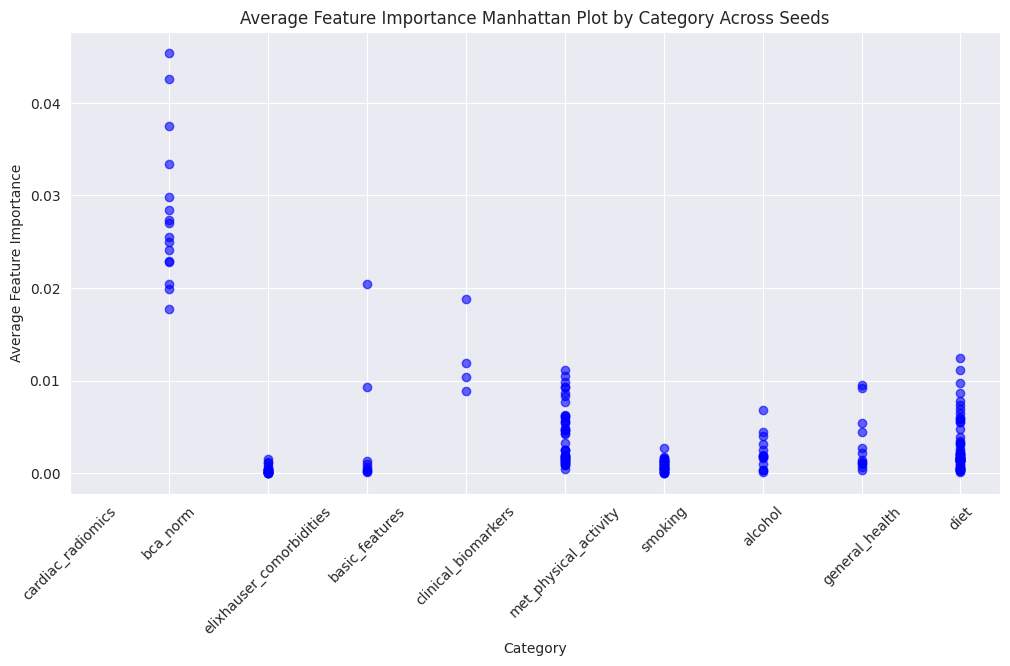

In [1089]:
import matplotlib.pyplot as plt
import pandas as pd

def plot_average_feature_importance_manhattan(all_feature_importances, category_dict):
    """
    Plots a Manhattan plot for average feature importances by category across seeds.

    Parameters:
    all_feature_importances (list): List of DataFrames, each containing feature importances for a seed 
                                    with columns 'feature', 'importance', and 'seed'.
    category_dict (dict): Dictionary where keys are category names and values are lists of features.

    Returns:
    None: Displays the Manhattan plot.
    """
    # Concatenate all DataFrames in the list to form a single DataFrame
    combined_feature_importances_df = pd.concat(all_feature_importances, ignore_index=True)
    
    # Calculate the average importance for each feature across all seeds
    avg_feature_importances_df = combined_feature_importances_df.groupby('feature')['importance'].mean().reset_index()
    
    # Create a reverse lookup for category from feature
    feature_to_category = {feature: category for category, features in category_dict.items() for feature in features}
    
    # Map each feature to its category
    avg_feature_importances_df['category'] = avg_feature_importances_df['feature'].map(feature_to_category)
    
    # Assign a numeric value to each category
    category_mapping = {category: idx for idx, category in enumerate(category_dict.keys())}
    avg_feature_importances_df['category_id'] = avg_feature_importances_df['category'].map(category_mapping)

    # Plotting the Manhattan plot
    plt.figure(figsize=(12, 6))
    plt.scatter(avg_feature_importances_df['category_id'], 
                avg_feature_importances_df['importance'], 
                c='blue', alpha=0.6)
    
    # Customize x-axis with category labels
    plt.xticks(ticks=list(category_mapping.values()), labels=list(category_mapping.keys()), rotation=45)
    plt.xlabel('Category')
    plt.ylabel('Average Feature Importance')
    plt.title('Average Feature Importance Manhattan Plot by Category Across Seeds')
    plt.grid(True)
    plt.show()
plot_average_feature_importance_manhattan(all_feature_importances, features_by_category)
# Example usage:
# Assuming 'all_feature_importances' is a list of DataFrames containing feature importances from all seeds
# with columns: 'feature', 'importance', and 'seed'.

# Example category_dict:
# category_dict = {
#     'Category1': ['feature1', 'feature2'],
#     'Category2': ['feature3', 'feature4'],
#     # ... other categories
# }
# plot_average_feature_importance_manhattan(all_feature_importances, category_dict)


In [886]:
importances = model.model.feature_importances_
feature_names = model.feature_metadata.get_features()
feature_importances = dict(zip(feature_names, importances))
print(feature_importances)

{'Alcohol intake frequency.': 0.005551728562227701, 'Former alcohol drinker_no': 0.00022644351710105306, 'Former alcohol drinker_yes': 0.0006714623354745714, 'Alcohol drinker status_current': 0.0002543904900642471, 'Alcohol intake versus 10 years previously_about the same': 0.0014689413747381904, 'Alcohol intake versus 10 years previously_less nowadays': 0.001984206207251163, 'Alcohol intake versus 10 years previously_more nowadays': 0.0010569942655345363, 'Reason for reducing amount of alcohol drunk_health precaution': 0.002497945017337872, 'Reason for reducing amount of alcohol drunk_illness or ill health': 0.0007385409021745606, 'Reason for reducing amount of alcohol drunk_other (united)': 7.680245910925952e-05, 'Reason for reducing amount of alcohol drunk_other reason': 0.002063777150820528, 'Alcohol usually taken with meals_it varies': 0.0017413519994670904, 'Alcohol usually taken with meals_no': 0.001284209867985884, 'Alcohol usually taken with meals_yes': 0.0012682386492340392, 

In [1023]:
# read json
import json
with open('./resources/feature_importances/features_by_category.json') as f:
    features_by_category = json.load(f)

In [851]:
# bca +/ cardiac + questionnaire
_visualize_results(results)

,accuracy,balanced_accuracy,f1,roc_auc
RF,0.724 ± 0.018,0.724 ± 0.018,0.652 ± 0.027,0.800 ± 0.007
XGB,0.632 ± 0.034,0.632 ± 0.034,0.584 ± 0.035,0.706 ± 0.008
NN_TORCH,0.646 ± 0.013,0.646 ± 0.013,0.669 ± 0.017,0.711 ± 0.005


In [768]:
# bca +/ cardiac + questionnaire
_visualize_results(results)

,accuracy,balanced_accuracy,f1,roc_auc
RF,0.623 ± 0.009,0.623 ± 0.010,0.613 ± 0.013,0.653 ± 0.010
XGB,0.609 ± 0.008,0.609 ± 0.008,0.598 ± 0.010,0.634 ± 0.008
NN_TORCH,0.622 ± 0.013,0.622 ± 0.013,0.606 ± 0.011,0.670 ± 0.007


In [961]:
train_data = ca.data[ca.data['split'] == 'train'].drop(columns=['split', 'eid', 'event', 'time_to_event']).copy()
train_data['label'] = ca.data[ca.data['split'] == 'train']['event'].copy()
test_data = ca.data[ca.data['split'] == 'test'].drop(columns=['split', 'eid', 'event', 'time_to_event']).copy()
test_data['label'] = ca.data[ca.data['split'] == 'test']['event'].copy()
val_data = ca.data[ca.data['split'] == 'val'].drop(columns=['split', 'eid', 'event', 'time_to_event']).copy()
val_data['label'] = ca.data[ca.data['split'] == 'val']['event'].copy()
test_val_data = pd.concat([test_data, val_data])
model = 'RF'
seed = SEEDS[0]

predictor = ag.TabularPredictor(label='label', eval_metric='balanced_accuracy', path=f'./autogluon/model_{model}_seed_{seed}', verbosity=2, problem_type='binary')
hyperparameters = {
    model: {
        model: {
            'random_state': seed,  # Use your seed here
            #'subsample': 0.98,
            #'colsample_bytree': 0.98,
        }
    },
}
predictor.fit(
    train_data=train_data,
    tuning_data=val_data,  # Set validation data for hyperparameter tuning
    hyperparameters=hyperparameters[model],
    time_limit=3600,   # Time limit per seed (10 minutes)
    num_bag_folds=0,  # No bagging
    num_stack_levels=0,  # No stacking
    presets='best_quality',  # Best quality preset
)

y_pred = predictor.predict(test_data)
y_proba = predictor.predict_proba(test_data)
y_proba = y_proba.to_numpy()[:, 1]
metrics = {
    "accuracy": accuracy_score(test_data['label'], y_pred),
    "balanced_accuracy": balanced_accuracy_score(test_data['label'], y_pred),
    "f1": f1_score(test_data['label'], y_pred),
    "roc_auc": roc_auc_score(test_data['label'], y_proba),
}

print(metrics)

fi = predictor.feature_importance(data=test_val_data, num_shuffle_sets=5)


Presets specified: ['best_quality']
Stack configuration (auto_stack=True): num_stack_levels=0, num_bag_folds=0, num_bag_sets=1
Beginning AutoGluon training ... Time limit = 3600s
AutoGluon will save models to "./autogluon/model_RF_seed_42"
=================== System Info ===================
AutoGluon Version:  1.1.0
Python Version:     3.10.13
Operating System:   Linux
Platform Machine:   x86_64
Platform Version:   #40~22.04.3-Ubuntu SMP PREEMPT_DYNAMIC Tue Jul 30 17:30:19 UTC 2
CPU Count:          48
Memory Avail:       230.44 GB / 251.53 GB (91.6%)
Disk Space Avail:   27.64 GB / 595.78 GB (4.6%)
Train Data Rows:    1140
Train Data Columns: 248
Tuning Data Rows:    127
Tuning Data Columns: 248
Label Column:       label
Problem Type:       binary
Preprocessing data ...
Selected class <--> label mapping:  class 1 = 1, class 0 = 0
Using Feature Generators to preprocess the data ...
Fitting AutoMLPipelineFeatureGenerator...
	Available Memory:                    235983.64 MB
	Train Data (O

{'accuracy': 0.6025236593059937, 'balanced_accuracy': 0.6024201894753602, 'f1': 0.5882352941176471, 'roc_auc': 0.6313589682350133}


	5.57s	= Actual runtime (Completed 10 of 10 shuffle sets)


In [964]:
len(fi[fi['importance'] >= 0])

119

In [860]:
fi[fi['p_value'] < 0.05]

,importance,stddev,p_value,n,p99_high,p99_low
Total abdominal adipose tissue index,0.031337,0.014561,0.004285,5,0.061318,0.001356
Posterior thigh muscle fat infiltration (MFI) (left),0.024440,0.017741,0.018458,5,0.060970,-0.012089
Anterior thigh fat-free muscle volume (right),0.020992,0.009929,0.004560,5,0.041435,0.000549
Visceral adipose tissue volume (VAT),0.019238,0.016763,0.031116,5,0.053754,-0.015278
Waist circumference,0.017423,0.010651,0.010812,5,0.039354,-0.004508
Posterior thigh fat-free muscle volume (right),0.013914,0.009949,0.017637,5,0.034398,-0.006570
Anterior thigh fat-free muscle volume (left),0.012311,0.009955,0.025290,5,0.032809,-0.008187
Summed minutes activity,0.010587,0.007276,0.015636,5,0.025568,-0.004395
Total thigh fat-free muscle volume,0.010557,0.007285,0.015833,5,0.025556,-0.004443
Muscle fat infiltration,0.010557,0.007285,0.015833,5,0.025556,-0.004443


In [701]:
#save the feature importance
fi.to_csv("/home/dmitrii/GitHub/ukbb_risk_assessment/analysisNumericFeatures/resources/cvdWOBCA_feature_importances.csv")

In [862]:
fi[fi['p_value'] < 0.05]

,importance,stddev,p_value,n,p99_high,p99_low
Total abdominal adipose tissue index,0.024380,0.016326,0.000543,10,0.041158,0.007602
Posterior thigh muscle fat infiltration (MFI) (left),0.021794,0.014315,0.000477,10,0.036505,0.007082
Visceral adipose tissue volume (VAT),0.019313,0.012863,0.000524,10,0.032533,0.006094
Anterior thigh fat-free muscle volume (right),0.019238,0.008991,0.000041,10,0.028478,0.009997
Waist circumference,0.014806,0.008267,0.000154,10,0.023303,0.006310
Anterior thigh muscle fat infiltration (MFI) (right),0.013158,0.010338,0.001498,10,0.023782,0.002534
Posterior thigh fat-free muscle volume (right),0.012175,0.007354,0.000269,10,0.019732,0.004618
Summed minutes activity,0.010557,0.006890,0.000457,10,0.017637,0.003476
Body mass index (BMI),0.010526,0.003699,0.000004,10,0.014327,0.006725
Anterior thigh fat-free muscle volume (left),0.009694,0.008667,0.003172,10,0.018602,0.000787


In [771]:
#save the feature importance
fi.to_csv("/home/dmitrii/GitHub/ukbb_risk_assessment/analysisNumericFeatures/resources/cvd2All_feature_importances_+val.csv")

In [1289]:
# bca / cardiac
_visualize_results(results)

,accuracy,balanced_accuracy,f1,roc_auc
RF,0.580 ± 0.015,0.580 ± 0.015,0.581 ± 0.017,0.614 ± 0.005
XGB,0.544 ± 0.011,0.544 ± 0.011,0.538 ± 0.016,0.566 ± 0.005
NN_TORCH,0.584 ± 0.028,0.585 ± 0.028,0.617 ± 0.009,0.642 ± 0.025


In [1268]:
# questionnaire
_visualize_results(results)

,accuracy,balanced_accuracy,f1,roc_auc
RF,0.551 ± 0.016,0.551 ± 0.016,0.518 ± 0.021,0.583 ± 0.005
XGB,0.543 ± 0.025,0.543 ± 0.025,0.533 ± 0.023,0.569 ± 0.013
NN_TORCH,0.539 ± 0.035,0.540 ± 0.034,0.645 ± 0.020,0.610 ± 0.015


In [15]:
import autogluon.tabular as ag
from autogluon.common import space
import numpy as np
from sklearn.metrics import accuracy_score, balanced_accuracy_score, f1_score, roc_auc_score

def train_and_evaluate(ca):
    seeds = ca.RANDOM_SET_SEED[:5]
    
    # Prepare the training and test datasets
    train_data = ca.data[ca.data['split'] == 'train'].drop(columns=['split', 'eid', 'event', 'time_to_event']).copy()
    train_data['label'] = ca.data[ca.data['split'] == 'train']['event'].copy()
    test_data = ca.data[ca.data['split'] == 'test'].drop(columns=['split', 'eid', 'event', 'time_to_event']).copy()
    test_data['label'] = ca.data[ca.data['split'] == 'test']['event'].copy()
    val_data = ca.data[ca.data['split'] == 'val'].drop(columns=['split', 'eid', 'event', 'time_to_event']).copy()
    val_data['label'] = ca.data[ca.data['split'] == 'val']['event'].copy()
    
    results = {}

    models_to_train = ['RF', 'XGB', 'NN_TORCH']

    for model in models_to_train:
        results[model] = {'accuracy': [], 'balanced_accuracy': [], 'f1': [], 'roc_auc': []}
        for seed in seeds:

            predictor = ag.TabularPredictor(label='label', eval_metric='f1', path=f'./autogluon/model_{model}_seed_{seed}', verbosity=2, problem_type='binary')

            hyperparameters = {
                'RF': {
                    'RF': {
                        'n_estimators': space.Int(100, 1000),
                        'max_depth': space.Int(5, 50),
                        'min_samples_split': space.Int(2, 10),
                        'min_samples_leaf': space.Int(1, 4),
                        'random_state': space.Int(seed, seed),
                    }
                },  
                'XGB': {
                    'XGB': {
                        'n_estimators': space.Int(100, 1000),
                        'learning_rate': space.Real(0.01, 0.3),
                        'max_depth': space.Int(3, 10),
                        'subsample': space.Real(0.5, 1.0),  # Tuning subsample
                        'colsample_bytree': space.Real(0.5, 1.0),  # Tuning colsample_bytree
                        'random_state': seed,
                    }
                },
                'NN_TORCH': {
                    'NN_TORCH': {
                        "num_layers": space.Int(1, 3),
                        "hidden_size": space.Int(64, 512),
                        "dropout_prob": space.Real(0.0, 0.5),
                        "learning_rate": space.Real(0.0001, 0.01),
                        "seed_value": seed,
                    }
                }
            }

            predictor.fit(
                train_data=train_data,
                tuning_data=val_data,  # Set validation data for hyperparameter tuning
                hyperparameters=hyperparameters[model],
                time_limit=600,   # Time limit per seed (10 minutes)
                num_bag_folds=0,  # No bagging
                num_stack_levels=0,  # No stacking
                presets='best_quality',  # Best quality preset
            )
            
            y_pred = predictor.predict(test_data)
            y_proba = predictor.predict_proba(test_data)
            y_proba = y_proba.to_numpy()[:, 1]
            metrics = {
                "accuracy": accuracy_score(test_data['label'], y_pred),
                "balanced_accuracy": balanced_accuracy_score(test_data['label'], y_pred),
                "f1": f1_score(test_data['label'], y_pred),
                "roc_auc": roc_auc_score(test_data['label'], y_proba),
            }
    
            # Store the metrics for this model and seed
            for metric in metrics:
                results[model][metric].append(metrics[metric])
        
    # Calculate mean and standard deviation across seeds for each model
    results_combined = {}
    for model_name in results:
        results_combined[model_name] = {}
        for metric in results[model_name]:
            results_combined[model_name][metric] = {
                "mean": np.mean(results[model_name][metric]),
                "std": np.std(results[model_name][metric])
            }
    
    return results_combined, predictor


results, predictor = train_and_evaluate(ca)


Presets specified: ['best_quality']
Stack configuration (auto_stack=True): num_stack_levels=0, num_bag_folds=0, num_bag_sets=1
Beginning AutoGluon training ... Time limit = 600s
AutoGluon will save models to "./autogluon/model_RF_seed_1514"
=================== System Info ===================
AutoGluon Version:  1.1.0
Python Version:     3.10.13
Operating System:   Linux
Platform Machine:   x86_64
Platform Version:   #40~22.04.3-Ubuntu SMP PREEMPT_DYNAMIC Tue Jul 30 17:30:19 UTC 2
CPU Count:          48
Memory Avail:       238.62 GB / 251.53 GB (94.9%)
Disk Space Avail:   96.38 GB / 595.78 GB (16.2%)
Train Data Rows:    864
Train Data Columns: 16
Tuning Data Rows:    97
Tuning Data Columns: 16
Label Column:       label
Problem Type:       binary
Preprocessing data ...
Selected class <--> label mapping:  class 1 = 1, class 0 = 0
Using Feature Generators to preprocess the data ...
Fitting AutoMLPipelineFeatureGenerator...
	Available Memory:                    244344.62 MB
	Train Data (Ori

AssertionError: Trainer has no fit models that can infer.